# Telecommute Models
For WORK FROM HOME (WFH) option, and FREQUENCY OF WORK FROM HOME, if WFH is available, we follow:

- Select variables for which the pearson correlation coefficient is greater than abs(0.1)
- Shortlist variables - Some of the variables might be infeasible or complatly unrelated 
- EDA of shortlisted variables
- Rate-base model estimation 

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 


os.chdir('../')
from utils import bootsratp
os.chdir('jupyter_notebooks')

In [ ]:
## Load raw data 
persons = pd.read_csv('NHTS_2017/perpub.csv')
households = pd.read_csv('NHTS_2017/hhpub.csv')

## Bay area households 
ba_filter = households['HH_CBSA'].isin(['41860','41940'])
households = households[ba_filter]
print ('Bar area household sample size:', ba_filter.sum())

## Avoid duplicated columns (to preserve column name in future merge)
cols_to_use = persons.columns.difference(households.columns)
cols_to_use = list(cols_to_use)
cols_to_use.insert(0,'HOUSEID')

## Merge persons and households tables 
persons = persons[cols_to_use].merge(households, how = 'right', on = 'HOUSEID')
population = np.round(persons['WTPERFIN'].sum(), 0)

print ('Bar area persons sample size:', persons.shape[0])
print ('Bar area weighted persons sample size:', population)

Bar area household sample size: 3248
Bar area persons sample size: 6772
Bar area weighted persons sample size: 6937089.0


# Data cleaning 

In [ ]:
WKRMHM_dict = {2: 0, -1: np.nan, -8: np.nan}

workers = persons[persons['OCCAT'].isin([1, 2, 3, 4])]
workers['wfh_option'] = workers['WKRMHM'].replace(WKRMHM_dict)
workers = workers.dropna(subset = ['wfh_option'])

print ('There are {} workers.'.format(workers.shape[0]))
print( '{} have the option of working from home'.format(workers.wfh_option.sum()))

There are 3042 workers.
980.0 have the option of working from home


# WFH Option 
Decision if an individual has or does not have the option of working from home 



## Variable Selection

In [ ]:
pearson_corr = workers.corr().loc['wfh_option'].abs().sort_values()
best_corr = pearson_corr[pearson_corr > 0.15].sort_values()
print ('There are {} variables with a absolute pearson correlation greater than 0.1.\nThese variables are: {}'.format(len(best_corr), list(best_corr.index)))

There are 12 variables with a absolute pearson correlation greater than 0.1.
These variables are: ['PERSONID', 'WKFTPT', 'RIDESHARE', 'PRICE', 'HHFAMINC', 'CARRODE', 'OCCAT', 'EDUC', 'FLEXTIME', 'WKFMHMXX', 'WKRMHM', 'wfh_option']


Shortlisted: 
- WKFTPT: Full time or part time worker 
- HHFAMINC: Household income 
- OCCAT: Job category 
- EDUC: Educational Attainment 

Other Variables Explored 
- R_AGE_IMP: Age 
- NUMADLT: Number of adults in the family 
- HBRESDN: Category of housing units per square mile in the census block group of the household's home location. 
- DRVRCNT: Number of drivers in the household
- HHVEHCNT: Household vehicle count 
- LIF_CYC: Life Cycle (family compositon, workers, children)

Dropped variables 
- PERSONID: Unique identifier [drop: variable not relevant] 
- RIDESHARE: count of rideshare app usage [infeasible]
- PRICE: Price of Gasoline Affects Travel [dropped: Infeasible]
- CARRODE: Count of people in vehicle to work [dropped: Infeasible]
- FLEXTIME: Flex time (Option to set or change start time) [dropped: Infeasible]
- WKFMHMXX: Number of days workk from home [dropped: Infeasible]

## E.D.A

In [ ]:
workers["wfh_option"].value_counts()

0.0    2062
1.0     980
Name: wfh_option, dtype: int64

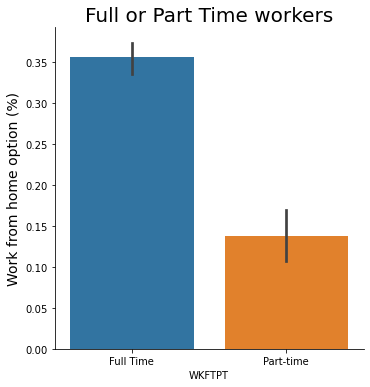

In [ ]:
variable = 'WKFTPT'
filter_ = workers.WKFTPT!=-8
sns.catplot(x=variable, y="wfh_option", kind="bar", data=workers[filter_])
plt.ylabel('Work from home option (%)',fontsize = 14);
# plt.xlabel('Full or Part Time workers',fontsize = 14)
plt.title('Full or Part Time workers', fontsize = 20)
plt.xticks((0,1), labels = ['Full Time','Part-time']);

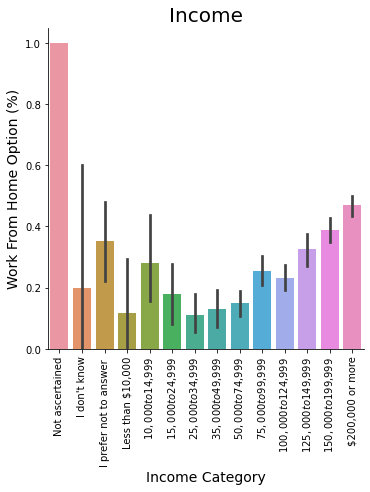

In [ ]:
income_labels = ['Not ascertained', "I don't know",  "I prefer not to answer ",
"Less than $10,000", "$10,000 to $14,999", '$15,000 to $24,999' , 
'$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $74,999', 
'$75,000 to $99,999','$100,000 to $124,999','$125,000 to $149,999',
'$150,000 to $199,999','$200,000 or more']

sns.catplot(x="HHFAMINC", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work From Home Option (%)',fontsize = 14);
plt.xlabel('Income Category',fontsize = 14)
plt.title('Income', fontsize = 20)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13],labels = income_labels, rotation = 90);

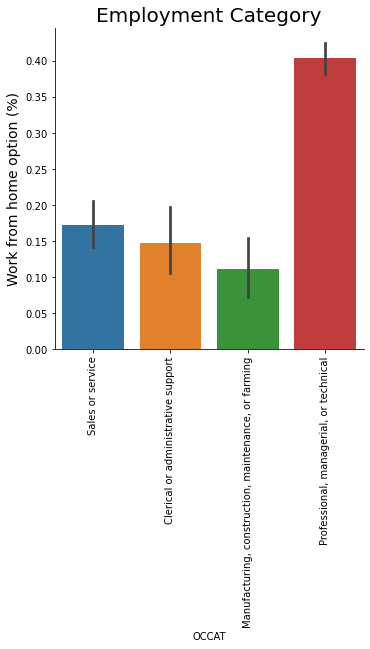

In [ ]:
variable = 'OCCAT'
edu_labels = ['Sales or service','Clerical or administrative support', 
              'Manufacturing, construction, maintenance, or farming', 
             'Professional, managerial, or technical']
sns.catplot(x=variable, y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
# plt.xlabel('Employment Category',fontsize = 14)
plt.title('Employment Category', fontsize = 20)
plt.xticks([0,1,2,3], labels = edu_labels, rotation = 90);

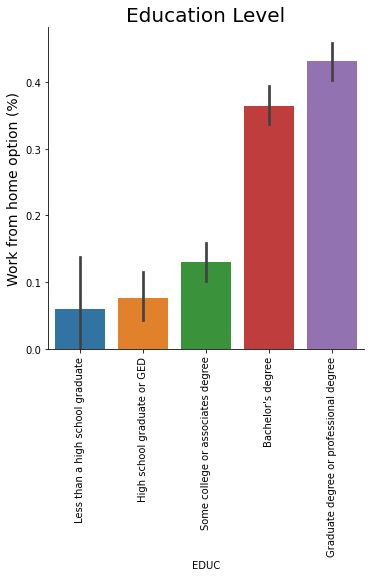

In [ ]:
variable = 'EDUC'
# filter_ = workers.WKFTPT!=-8

educ_labels = ['Less than a high school graduate', 
                'High school graduate or GED',
                'Some college or associates degree',
                "Bachelor's degree" ,
                "Graduate degree or professional degree" ]

sns.catplot(x=variable, y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
# plt.xlabel('Education Level',fontsize = 14)
plt.title('Education Level', fontsize = 20)
plt.xticks([0,1,2,3,4], educ_labels, rotation = 90);

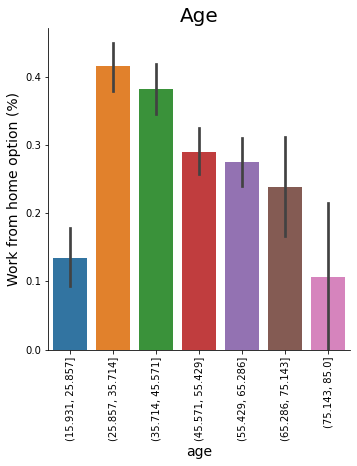

In [ ]:
workers['age'] = pd.cut(workers["R_AGE_IMP"], bins = 7)
sns.catplot(x="age", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('age',fontsize = 14)
plt.title('Age', fontsize = 20)
plt.xticks(rotation = 90);

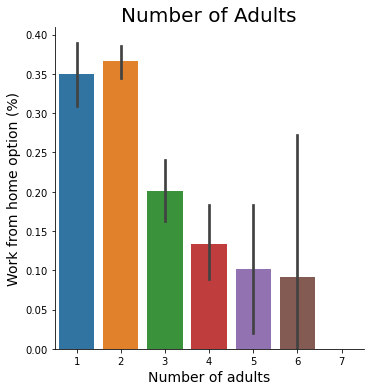

In [ ]:
sns.catplot(x="NUMADLT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Number of adults',fontsize = 14)
plt.title('Number of Adults', fontsize = 20);

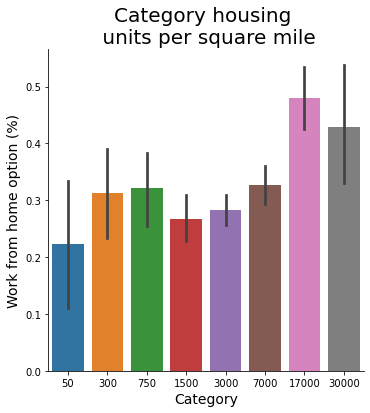

In [ ]:
sns.catplot(x="HBRESDN", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Category',fontsize = 14)
plt.title('Category housing \n units per square mile', fontsize = 20);

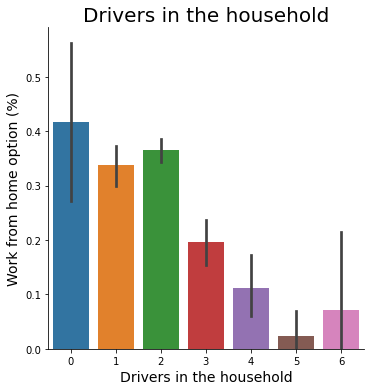

In [ ]:
sns.catplot(x="DRVRCNT", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Drivers in the household',fontsize = 14)
plt.title('Drivers in the household', fontsize = 20);

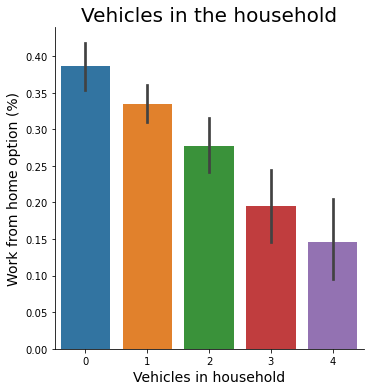

In [ ]:
workers['cars'] = pd.cut(workers.HHVEHCNT, (0,1,2,3,4,20), labels = [0,1,2,3,4])
sns.catplot(x="cars", y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14);
plt.xlabel('Vehicles in household',fontsize = 14)
plt.title('Vehicles in the household', fontsize = 20);
# workers["HHVEHCNT"].value_counts().sort_index()

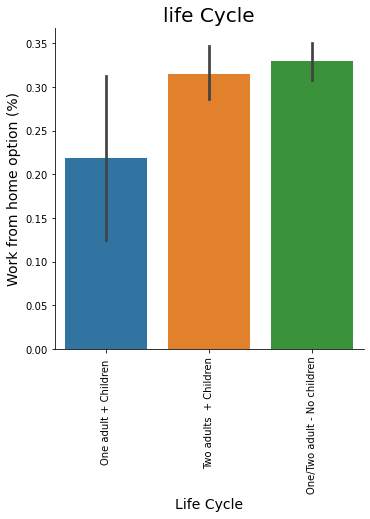

In [ ]:
cat_replace = {1: 2,2:2,3:0,4:1,5:0,6:1,7:0,8:1,9: 2, 10: 2}
workers['fam_type'] = workers['LIF_CYC'].replace(cat_replace)

# 0. One adult + Children 
# 1. Two adults  + Children
# 2. One/Two adult - No children 

sns.catplot(x='fam_type', y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('Life Cycle',fontsize = 14)
plt.title('life Cycle', fontsize = 20)
plt.xticks([0,1,2], labels = ['One adult + Children ', 
                             'Two adults  + Children', 
                             'One/Two adult - No children' ], rotation = 90)
plt.xticks(rotation = 90);

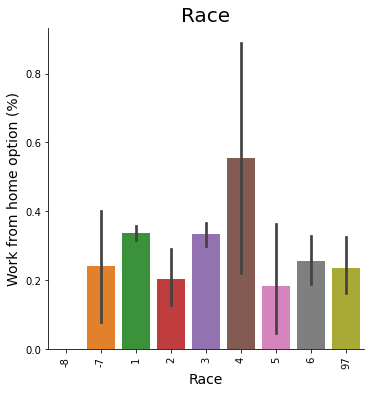

In [ ]:
sns.catplot(x='R_RACE', y="wfh_option", kind="bar", data=workers)
plt.ylabel('Work from home option (%)',fontsize = 14)
plt.xlabel('Race',fontsize = 14)
plt.title('Race', fontsize = 20)
plt.xticks(rotation = 90);

## Binary Model

In [ ]:
import statsmodels.api as sm

In [ ]:
# Job sector 
workers['job_sector'] = (workers['OCCAT']>=4).astype(int)

#Age 
workers['age_cat'] = pd.cut(workers['R_AGE_IMP'], bins = [15,25,45, 100],
                       labels = [0,1,2])
workers['age:<25'] = (workers['age_cat'] == 0).astype(float)
workers['age:25-45'] = (workers['age_cat'] == 1).astype(float)
workers['age:45-60'] = (workers['age_cat'] == 2).astype(float)

#Income
workers['income_cat'] = pd.cut(workers['HHFAMINC'], bins = [0, 6, 9, 11],
                       labels = [0, 1, 2])

workers['income:low_income'] = (workers['income_cat'] == 0).astype(float)
workers['income:middle_income'] = (workers['income_cat'] == 1).astype(float)

# Full-time worker
workers['full_worker'] = workers['WKFTPT'].replace({2:0})

#Adults 
workers['adults'] = (workers['NUMADLT'] <= 2).astype(float)

In [ ]:

# categories = ['job_sector','income_cat','age_cat', 'WKFTPT']
# categories = ['job_sector','income_cat', 'WKFTPT']
categories = ['job_sector', 'adults', 'full_worker', 
              'income:low_income','income:middle_income','R_AGE_IMP']

categories = ['job_sector', 'adults',
              'income:low_income','income:middle_income','R_AGE_IMP']  

y = workers.wfh_option
X = workers[categories]
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.572205
         Iterations 6
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.090     
Dependent Variable:   wfh_option        AIC:               3491.2965 
Date:                 2022-04-22 10:53  BIC:               3521.3978 
No. Observations:     3042              Log-Likelihood:    -1740.6   
Df Model:             4                 LL-Null:           -1911.8   
Df Residuals:         3037              LLR p-value:       7.6633e-73
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
job_sector            0.6817   0.0950   7.1753 0.0000  0.4955  0.8679
adults          

## Rate-based model

In [ ]:
categories = ['job_sector','income_cat', 'age_cat']
wfh_option_model = bootsratp(workers, 'wfh_option', categories, func= 'mean')


In [ ]:
wfh_option_model['mean'].rename('rate').reset_index().to_csv('telework_option_rates.csv', index = False)

The final rates exclude the variable "adults" to maintain enough observations per rate-group. Ideally, each group would have 30+ observations. 

# WFH Frequency
How many days per week a person works from home if WFH is an option

In [21]:
wfh_workers = workers[workers.wfh_option == 1]
wfh_workers = workers[workers['WKFMHMXX'] >= 0]

wfh_workers['day_wfh'] = pd.cut(wfh_workers['WKFMHMXX'], bins = [-1,2,8,15,np.inf], labels = [0, 1, 2, 3]).astype(int)
print ('There are {} observation with WORK FROM HOME as option'.format(wfh_workers.shape[0]))

There are 976 observation with WORK FROM HOME as option


In [22]:
pearson_corr = wfh_workers.corr().loc['WKFMHMXX'].abs().sort_values()
best_corr = pearson_corr[pearson_corr > 0.1].sort_values()
print ('There are {} variables with a absolute pearson correlation greater than 0.1. \n These variables are: {}'.format(len(best_corr), list(best_corr.index)))
best_corr

There are 6 variables with a absolute pearson correlation greater than 0.1. 
 These variables are: ['HHVEHCNT', 'PAYPROF', 'full_worker', 'WKFTPT', 'day_wfh', 'WKFMHMXX']


HHVEHCNT       0.100413
PAYPROF        0.123176
full_worker    0.149318
WKFTPT         0.149318
day_wfh        0.913277
WKFMHMXX       1.000000
Name: WKFMHMXX, dtype: float64

Shortlisted 
 - HHVEHCNT: Household vehicle count
 - WKFTPT: Full time - Part time worker

Dropped variables
  - PAYPROF: Work for pay in previous week 

1    913
2     63
Name: WKFTPT, dtype: int64

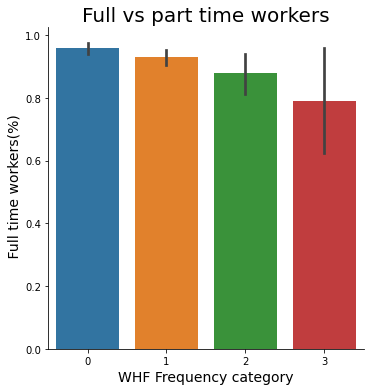

In [23]:
sns.catplot(x="day_wfh", y="full_worker", kind="bar", data=wfh_workers)
plt.ylabel(' Full time workers(%)',fontsize = 14);
plt.xlabel('WHF Frequency category',fontsize = 14)
plt.title('Full vs part time workers', fontsize = 20);
wfh_workers["WKFTPT"].value_counts()

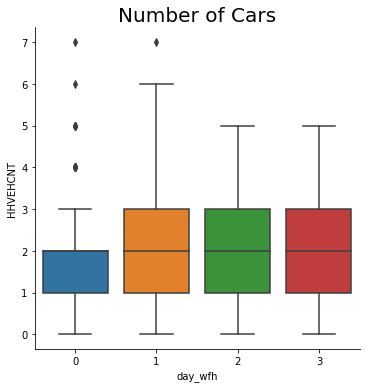

In [24]:
sns.catplot(x="day_wfh", y="HHVEHCNT", kind="box",data=wfh_workers)
plt.title('Number of Cars', fontsize = 20);

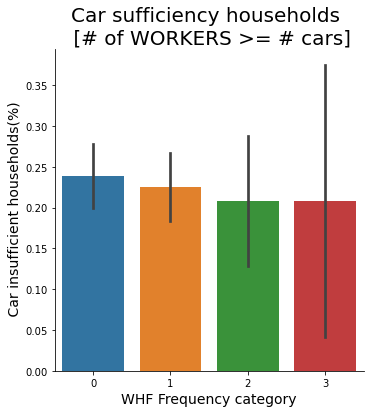

In [25]:
wfh_workers['car_suff'] = (wfh_workers['WRKCOUNT'] > wfh_workers['HHVEHCNT']).astype(int)

sns.catplot(x="day_wfh", y='car_suff', kind="bar", data=wfh_workers)
plt.ylabel(' Car insufficient households(%)',fontsize = 14);
plt.xlabel('WHF Frequency category',fontsize = 14)
plt.title('Car sufficiency households \n [# of WORKERS >= # cars]', fontsize = 20);

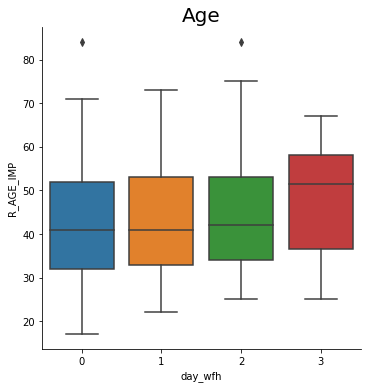

In [26]:
sns.catplot(x="day_wfh", y="R_AGE_IMP", kind="box",data=wfh_workers)
plt.title('Age', fontsize = 20);

It seems that non of the variables explains the number of days a worker telecommutes during the week. 

In [27]:
bootsratp(wfh_workers, 'day_wfh')

,mean,count,lower_bound,upper_bound
0,0.475889,465,0.445401,0.506378
1,0.395737,386,0.365563,0.425910
2,0.103721,101,0.084887,0.122555
3,0.024653,24,0.015033,0.034273
